In [2]:
import jax
import jax.numpy as jnp
import jax.random as random
from jax.scipy.special import expit, logit
import numpy as np
from tqdm import tqdm
import numpyro
import numpyro.distributions as dist
import src.Aux_functions as aux
from itertools import combinations
import matplotlib.pyplot as plt 
import time 
import blackjax 

print("JAX version: {}".format(jax.__version__))
print("blackjax version: {}".format(blackjax.__version__))
print("NumPyro version: {}".format(numpyro.__version__))



JAX version: 0.4.28
blackjax version: 1.2.0
NumPyro version: 0.15.2


In [3]:
key = random.PRNGKey(0)
key = random.split(key, 1)[0]

# Generate some data
n = 500
triu_dim = n*(n-1)//2

x = random.normal(key, shape=(n,))*3
x2 = random.binomial(key, n=1, p=0.1, shape=(n,))
idx_pairs = list(combinations(range(len(x)), 2))
x_diff = jnp.array([abs(x[i] - x[j]) for i, j in idx_pairs])
x2_or = jnp.array([1 if (x2[i] + x2[j] == 1) else 0 for i, j in idx_pairs])


print(x.shape, x2.shape, x_diff.shape, x2_or.shape)

# Network data

df_edges = jnp.transpose(jnp.stack([jnp.ones(triu_dim), x_diff, x2_or]))
theta = jnp.array([-2.5, -0.5, 1.5])
# gamma = jnp.array([1.1, 0.2, -1, 1])
gamma = jnp.array([logit(.9), logit(.1)])

triu_star_probs = expit(jnp.dot(df_edges, theta))
triu_star = random.binomial(key, n=1, p=triu_star_probs, shape=(triu_dim,))


# triu_obs_probs = expit((triu_star * gamma[0]) + (1 - triu_star) * (gamma[1] + jnp.dot(df_edges, gamma[2:])))
triu_obs_probs = expit(triu_star*gamma[0] + (1 - triu_star)*gamma[1])
triu_obs = random.binomial(key, n=1, p=triu_obs_probs, shape=(triu_dim,))

print(triu_star.shape, triu_obs.shape)

# Outcome data

@jax.jit
def degree_centrality(adj_matrix):
    """
    Compute normalized degree centrality for all nodes in the network using JAX.
    
    Parameters:
    adj_matrix (jnp.ndarray): Square adjacency matrix (n x n)
    
    Returns:
    jnp.ndarray: Vector of normalized degree centralities
    """
    # Compute degrees (sum of rows for undirected graph)
    degrees = jnp.sum(adj_matrix, axis=1)
    
    # Normalize by maximum possible degree (n-1)
    n = adj_matrix.shape[0]
    return degrees / (n - 1)
    
@jax.jit
def compute_exposures(triu_star, Z):
    mat_star = aux.Triu_to_mat(triu_star)
    # eigen_cen = aux.eigen_centrality(mat_star)
    deg_cen = degree_centrality(mat_star)
    return aux.zeigen_value(Z, deg_cen, mat_star)

mat_star = aux.Triu_to_mat(triu_star)
Z = random.binomial(key, n=1, p=0.5, shape=(n,))
# exposures = jnp.dot(mat_star, Z)
exposures = compute_exposures(triu_star, Z)

df_nodes = jnp.transpose(jnp.stack([jnp.ones(n), Z, x, exposures]))
eta = jnp.array([-1, 3, -0.25, 3])

mean_y = jnp.dot(df_nodes, eta)
sig_y = 1

Y = random.normal(key, shape=(n,))*sig_y + mean_y

print(Y.shape)



(500,) (500,) (124750,) (124750,)
(124750,) (124750,)
(500,)


mean exposure:  0.33126655 
 std exposure:  0.3022698 
 median exposure:  0.26553106


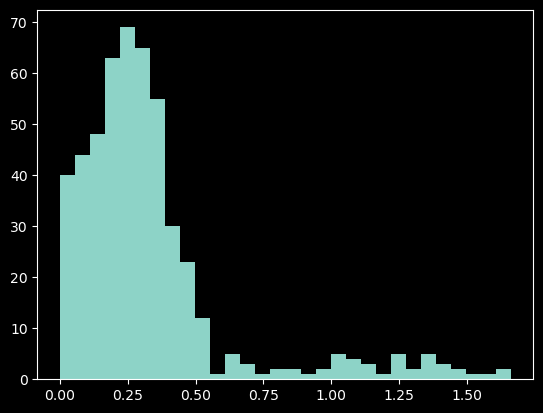

In [4]:
plt.hist(exposures, bins=30)
print("mean exposure: ", jnp.mean(exposures), "\n",
      "std exposure: ", jnp.std(exposures), "\n",
      "median exposure: ", jnp.median(exposures))

(array([17., 14., 16., 37., 22., 37., 83., 60., 46., 55., 46., 11.,  5.,
         4.,  2.,  1.,  3.,  2.,  3.,  3.,  6.,  2.,  4.,  3.,  5.,  5.,
         5.,  0.,  1.,  2.]),
 array([ 1.        ,  3.29999995,  5.5999999 ,  7.9000001 , 10.19999981,
        12.5       , 14.80000019, 17.10000038, 19.39999962, 21.70000076,
        24.        , 26.29999924, 28.60000038, 30.89999962, 33.20000076,
        35.5       , 37.79999924, 40.09999847, 42.40000153, 44.70000076,
        47.        , 49.29999924, 51.59999847, 53.90000153, 56.20000076,
        58.5       , 60.79999924, 63.09999847, 65.40000153, 67.69999695,
        70.        ]),
 <BarContainer object of 30 artists>)

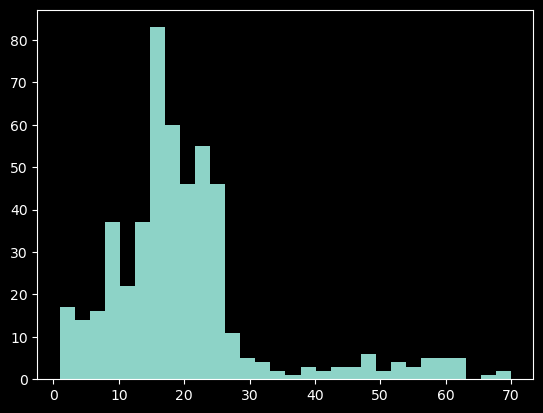

In [5]:
plt.hist(jnp.sum(mat_star, axis=1), bins=30)

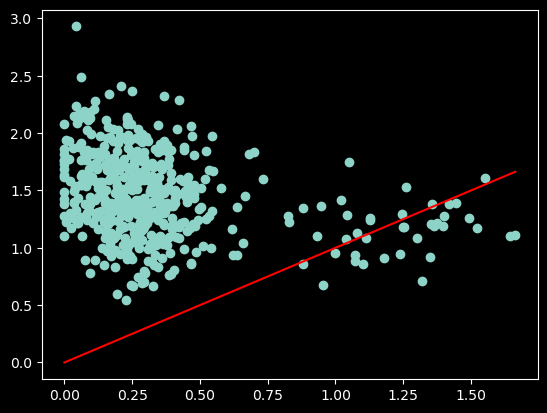

In [6]:
expos_obs = compute_exposures(triu_obs, Z)

plt.scatter(exposures, expos_obs)
# create y~x line
x_line = np.linspace(min(exposures), max(exposures), 100)
y_line = x_line
plt.plot(x_line, y_line, color='red')

(array([ 14.,  45.,  96., 129., 104.,  72.,  31.,   7.,   1.,   1.]),
 array([0.54909819, 0.78717434, 1.02525043, 1.26332664, 1.50140274,
        1.73947895, 1.97755504, 2.21563125, 2.45370746, 2.69178343,
        2.92985964]),
 <BarContainer object of 10 artists>)

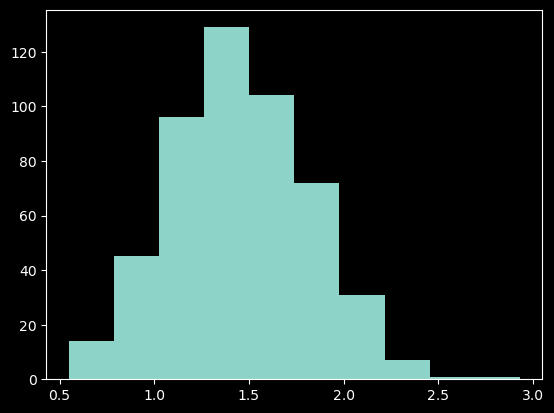

In [7]:
plt.hist(expos_obs)

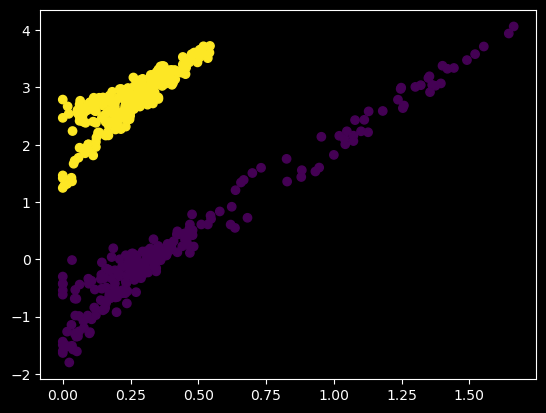

In [8]:
plt.scatter(exposures, Y, c=Z)

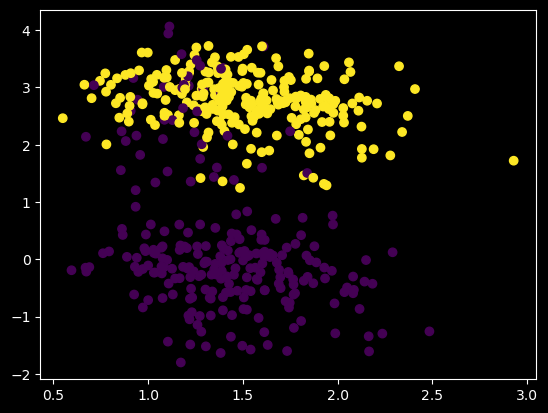

In [9]:
plt.scatter(expos_obs, Y, c=Z)

In [10]:
@jax.jit
def A_star_cond_log_post(triu_star, triu_obs, df_edges, theta, gamma):
    logits_a_star = jnp.dot(df_edges, theta)
    # a_star_log_likelihood = triu_star * (-jnp.log1p(jnp.exp(-logits_a_star))) + (1 - triu_star) * (-jnp.log1p(jnp.exp(logits_a_star)))
    a_star_log_likelihood = triu_star*logits_a_star - jnp.log1p(jnp.exp(logits_a_star))

    # logits_a_obs = (triu_star * gamma[0]) + (1 - triu_star) * (gamma[1] + jnp.dot(df_edges, gamma[2:]))
    logits_a_obs = triu_star*gamma[0] + (1 - triu_star)*gamma[1]
    # a_obs_log_likelihood = triu_obs * (-jnp.log1p(jnp.exp(-logits_a_obs))) + (1 - triu_obs) * (-jnp.log1p(jnp.exp(logits_a_obs)))
    a_obs_log_likelihood = triu_obs*logits_a_obs - jnp.log1p(jnp.exp(logits_a_obs))

    log_prob = a_star_log_likelihood + a_obs_log_likelihood 
    log_prob_sum = jnp.sum(log_prob)

    return log_prob_sum, log_prob


@jax.jit
def A_star_cond_log_post_with_Y(triu_star, triu_obs, df_edges, theta, gamma, Y, X, Z, eta):
    log_prob_sum_n, log_prob_n = A_star_cond_log_post(triu_star, triu_obs, df_edges, theta, gamma)
    # curr_a_star = aux.Triu_to_mat(triu_star)
    # exposures = jnp.dot(curr_a_star, Z)
    exposures = compute_exposures(triu_star, Z)
    df_nodes = jnp.transpose(jnp.stack([jnp.ones(n), Z, X, exposures]))
    mean_y = jnp.dot(df_nodes, eta)
    y_log_likelihood = - 0.5 * jnp.sum((Y - mean_y)**2)

    return log_prob_sum_n + y_log_likelihood, log_prob_n + y_log_likelihood


In [11]:
print(A_star_cond_log_post(triu_star, triu_obs, df_edges, theta, gamma))
print(A_star_cond_log_post_with_Y(triu_star, triu_obs, df_edges, theta, gamma, Y, x, Z, eta))

(Array(-58696.355, dtype=float32), Array([-0.12490855, -0.12892868, -0.10976784, ..., -0.12576193,
       -0.16975422, -0.12192333], dtype=float32))
(Array(-58968.49, dtype=float32), Array([-272.25696, -272.261  , -272.24182, ..., -272.2578 , -272.30182,
       -272.25397], dtype=float32))


(124750,) (124750,)
-58968.49 
 [-4.0041294  -5.6607227  -0.09660435 -5.2226014  -1.4445118  -6.456949
 -7.467518   -1.1351991  -4.471914  ]


(array([1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 3.000e+00,
        0.000e+00, 1.000e+00, 4.000e+00, 3.000e+00, 4.000e+00, 7.000e+00,
        5.000e+00, 4.000e+00, 1.400e+01, 9.000e+00, 1.100e+01, 2.100e+01,
        1.700e+01, 2.700e+01, 3.700e+01, 5.100e+01, 6.900e+01, 6.300e+01,
        8.100e+01, 1.080e+02, 1.360e+02, 1.450e+02, 1.750e+02, 1.890e+02,
        2.370e+02, 2.840e+02, 3.130e+02, 3.780e+02, 4.310e+02, 4.880e+02,
        5.810e+02, 6.200e+02, 7.120e+02, 8.300e+02, 9.240e+02, 1.080e+03,
        1.175e+03, 1.405e+03, 1.563e+03, 1.642e+03, 1.701e+03, 1.774e+03,
        1.921e+03, 2.063e+03, 2.324e+03, 2.577e+03, 2.765e+03, 3.015e+03,
        3.242e+03, 3.512e+03, 3.645e+03, 3.971e+03, 4.159e+03, 4.356e+03,
        4.727e+03, 4.842e+03, 5.192e+03, 5.397e+03, 5.603e+03, 5.784e+03,
        5.887e+03, 5.899e+03, 5.098e+03, 2.656e+03, 1.561e+03, 1.291e+03,
        1.286e+03, 1.260e+03, 1.290e+03, 1.293e+03, 1.328e+03, 1.277e+03,
        1.001e+03, 4.010e+02, 3.070e+0

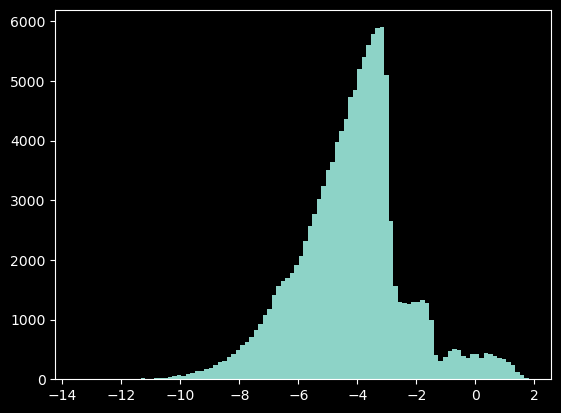

In [12]:
# val_grad_fn = jax.value_and_grad(A_star_cond_log_post, argnums=0, has_aux=True) 
val_grad_fn = jax.value_and_grad(A_star_cond_log_post_with_Y, argnums=0, has_aux=True) 

# (sum_logprob, log_prob), gradient = val_grad_fn(triu_star, triu_obs, df_edges, theta, gamma)
(sum_logprob, log_prob), gradient = val_grad_fn(triu_star, triu_obs, df_edges, theta, gamma, Y, x, Z, eta)
print(log_prob.shape, gradient.shape)
print(sum_logprob, "\n", gradient[1:10])

# create histogram of gradient

plt.hist(gradient, bins=100)

(array([1.000e+00, 0.000e+00, 2.000e+00, 3.000e+00, 3.000e+00, 4.000e+00,
        7.000e+00, 1.000e+01, 1.400e+01, 1.600e+01, 3.100e+01, 3.700e+01,
        6.800e+01, 9.500e+01, 1.210e+02, 1.880e+02, 2.280e+02, 2.860e+02,
        3.880e+02, 4.630e+02, 6.010e+02, 7.110e+02, 8.710e+02, 1.048e+03,
        1.280e+03, 1.512e+03, 1.854e+03, 2.213e+03, 2.722e+03, 3.130e+03,
        3.785e+03, 4.374e+03, 5.009e+03, 5.770e+03, 6.492e+03, 7.208e+03,
        7.979e+03, 8.521e+03, 9.261e+03, 9.643e+03, 9.797e+03, 5.933e+03,
        2.451e+03, 2.147e+03, 2.109e+03, 2.128e+03, 2.125e+03, 9.530e+02,
        3.960e+02, 5.130e+02, 5.580e+02, 6.330e+02, 6.940e+02, 6.310e+02,
        7.490e+02, 9.460e+02, 8.180e+02, 6.070e+02, 3.030e+02, 6.900e+01,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+01,
        1.900e+02, 2.470e+02, 2.270e+02, 2.370e+02, 2.020e+02, 2.980e+02,
        6.080e+02, 6.300e+02, 4.590e+0

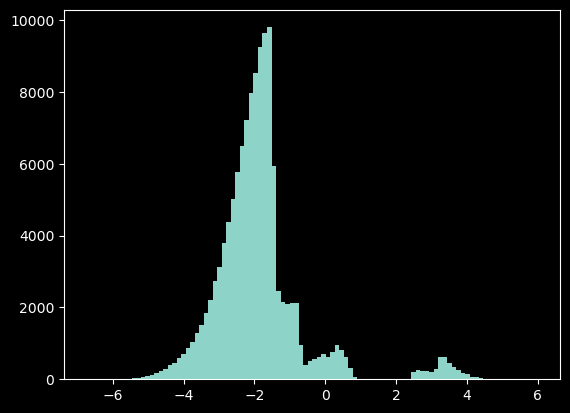

In [13]:

# score_grad = jnp.sum(-(2*triu_star-1)*gradient)
score_grad = -(2*triu_star-1)*gradient

plt.hist(score_grad/2, bins=100)

# plt.hist(grad_manual - score_grad, bins=100)

In [14]:
# g_grad = jnp.exp(score_grad) / (jnp.exp(score_grad) + 1)
# g_grad = score_grad / 2

# print(g_grad.min(), g_grad.max())
# tst_samp = random.categorical(key, logits=g_grad, shape=(1,))
# print(tst_samp, g_grad[tst_samp])

def weighted_sample_and_logprobs(key, scores, M):
    # Get samples using Gumbel-max trick
    gumbel_noise = random.gumbel(key, shape=scores.shape)
    perturbed = scores + gumbel_noise
    selected_indices = jnp.argsort(-perturbed)[:M]

     # Compute log probabilities
    # log_probs = jax.nn.log_softmax(scores)
    log_probs = jax.nn.log_softmax(scores)
    # print("min log prob: ", jnp.min(log_probs), "max log prob: ", jnp.max(log_probs), "\n",
    #       "std log prob: ", jnp.std(log_probs), "mean log prob: ", jnp.mean(log_probs), "\n",
    #       "median log prob: ", jnp.median(log_probs))
    selected_log_probs = log_probs[selected_indices]
    # print("select", selected_log_probs)

    return selected_indices, selected_log_probs.sum()

@jax.jit
def propsal_logprobs(idx, scores):
    log_probs = jax.nn.log_softmax(scores)
    return log_probs[idx].sum()



# w_samp, w_logprob = weighted_sample_and_logprobs(key, g_grad, 3)
# print(w_samp, g_grad[w_samp])
# print(w_logprob)


In [15]:
TRIU_LEN = triu_star.shape[0]
BATCH_PROP = .001
# BATCH_LEN = int(TRIU_LEN * BATCH_PROP)
# BATCH_LEN = 500
# BATCH_LEN = 5
# BATCH_LEN = 2*jnp.ceil(jnp.log(n)).astype(int)
# BATCH_LEN = jnp.ceil(jnp.log(TRIU_LEN)).astype(int)
BATCH_LEN = jnp.ceil(jnp.log(TRIU_LEN)/2).astype(int)
print(BATCH_LEN)

@jax.jit
def triu_star_update(triu_star, triu_obs, df_edges, theta, gamma,
                      Y, X, Z, eta, key, alpha = 1.0):

    key1, key2 = random.split(key, 2)

    (f_baseline,_), baseline_grad = val_grad_fn(triu_star, triu_obs, df_edges, theta, gamma, Y, X, Z, eta)
    baseline_scores = (-(2*triu_star-1)*baseline_grad)/2

    # idx, forward_logprob = weighted_sample_and_logprobs(key1, cur_scores*jnp.exp(-alpha), BATCH_LEN)
    idx, forward_logprob = weighted_sample_and_logprobs(key1, baseline_scores*jnp.exp(-alpha), BATCH_LEN)

    new_triu_star = triu_star.at[idx].set(1 - triu_star[idx])

    # backward proposal
    (f_proposed,_), backward_grad = val_grad_fn(new_triu_star, triu_obs, df_edges,
                                        theta, gamma, Y, X, Z, eta)
    backward_scores = (-(2*new_triu_star-1)*backward_grad)/2
    backward_logprob = propsal_logprobs(idx, backward_scores*jnp.exp(-alpha))

    # get acceptance ratio (exp of log probs)
    acceptance_ratio = jnp.clip(jnp.exp(f_proposed - f_baseline + backward_logprob - forward_logprob),
                                a_max=1)
    # accept or reject
    accept = random.uniform(key2) <= acceptance_ratio

    # update triu_star
    new_triu_star = jax.lax.select(accept, new_triu_star, triu_star)
    # new_scores = jax.lax.select(accept, backward_scores, cur_scores)
    new_logpost = jax.lax.select(accept, f_proposed, f_baseline)
    # return new_triu_star, acceptance_ratio
    # return new_triu_star, acceptance_ratio, new_scores, new_logpost
    return new_triu_star, acceptance_ratio, new_logpost
    
     

6


In [16]:
@jax.jit
def adaptive_step_size(alpha, acceptance_rate, target_rate=0.574, gamma=0.05):
    """
    Updates step size alpha based on the observed acceptance rate.
    """
    adjustment = gamma * (target_rate - acceptance_rate)
    return alpha + adjustment

In [17]:
# make noisy triu_star
key,_  = random.split(key)
triu_star_noisy = (triu_star * random.binomial(key, n=1, p=0.9, shape=(triu_dim,)) +
                   (1-triu_star) * random.binomial(key, n=1, p=0.1, shape=(triu_dim,)))

eta_n = eta 
eta_n = eta_n.at[3].set(eta_n[3] - 2.0)
theta_n = theta
theta_n = theta_n.at[1].set(theta_n[1] - 1.5)
# theta_n[1] = theta_n[1] - 1.5
# test A_star update

# alpha = jnp.log(2.0)
alpha = 1.0
n_iter = 3000
new_triu_star = triu_star_noisy
# new_triu_star = triu_obs
exposures_lst = [compute_exposures(new_triu_star, Z)]
log_post = []
acceptance_rates = []
# acceptance_rates = jnp.zeros
ADAPT_WINDOW = 100


start = time.time()
for i in tqdm(range(int(n_iter))):
    key, _ = random.split(key)
  
    new_triu_star, acc, logpost = triu_star_update(new_triu_star, triu_obs, df_edges,
                                      theta, gamma, Y, x, Z, eta, key, alpha=alpha)
    # new_triu_star, acc, cur_scores, cur_logpost = triu_star_update(new_triu_star,
    #                                                                cur_scores, cur_logpost,
    #                                                                 triu_obs, df_edges,
    #                                   theta_n, gamma, Y, x, Z, eta_n, key, alpha=alpha)
    exposures_lst.append(compute_exposures(new_triu_star, Z))
    acceptance_rates.append(acc)
    log_post.append(logpost)
    
    if i % ADAPT_WINDOW == 0:
        # mean_acceptance_rate = jnp.mean(jnp.array(acceptance_rates[-ADAPT_WINDOW:]))
        mean_acceptance_rate = np.mean(acceptance_rates[-ADAPT_WINDOW:])
        alpha = adaptive_step_size(alpha, mean_acceptance_rate)
        print(f"Iteration {i}, New Alpha: {alpha}, Acceptance Rate: {mean_acceptance_rate}")

        # eta_n[-1] = eta_n[-1] + 0.04
        # eta_n = eta_n.at[3].set(eta_n[3] + 0.02)
        # theta_n[1] = theta_n[1] + 0.03
        # theta_n = theta_n.at[1].set(theta_n[1] + 0.015)

print("for loop total time: ", time.time() - start)

    


  0%|          | 1/3000 [00:02<1:46:37,  2.13s/it]

Iteration 0, New Alpha: 0.9786999821662903, Acceptance Rate: 1.0


  3%|▎         | 104/3000 [00:11<03:27, 13.98it/s]

Iteration 100, New Alpha: 0.9573999643325806, Acceptance Rate: 1.0


  7%|▋         | 202/3000 [00:17<03:04, 15.21it/s]

Iteration 200, New Alpha: 0.9360999464988708, Acceptance Rate: 1.0


 10%|█         | 304/3000 [00:24<03:02, 14.78it/s]

Iteration 300, New Alpha: 0.9147999286651611, Acceptance Rate: 1.0


 13%|█▎        | 404/3000 [00:31<02:55, 14.83it/s]

Iteration 400, New Alpha: 0.8939878940582275, Acceptance Rate: 0.9902401566505432


 17%|█▋        | 502/3000 [00:38<02:46, 15.04it/s]

Iteration 500, New Alpha: 0.8730552792549133, Acceptance Rate: 0.9926517009735107


 20%|██        | 602/3000 [00:45<03:02, 13.13it/s]

Iteration 600, New Alpha: 0.8521202206611633, Acceptance Rate: 0.9927012920379639


 23%|██▎       | 704/3000 [00:52<02:25, 15.76it/s]

Iteration 700, New Alpha: 0.8313652276992798, Acceptance Rate: 0.9891000390052795


 27%|██▋       | 802/3000 [00:59<02:46, 13.18it/s]

Iteration 800, New Alpha: 0.8122217059135437, Acceptance Rate: 0.9568702578544617


 30%|███       | 904/3000 [01:07<02:18, 15.18it/s]

Iteration 900, New Alpha: 0.7924841046333313, Acceptance Rate: 0.9687517285346985


 33%|███▎      | 1002/3000 [01:13<02:22, 13.99it/s]

Iteration 1000, New Alpha: 0.7736690640449524, Acceptance Rate: 0.9503005743026733


 37%|███▋      | 1102/3000 [01:21<02:31, 12.56it/s]

Iteration 1100, New Alpha: 0.7553436756134033, Acceptance Rate: 0.9405075907707214


 40%|████      | 1204/3000 [01:29<01:57, 15.28it/s]

Iteration 1200, New Alpha: 0.7380984425544739, Acceptance Rate: 0.9189044237136841


 43%|████▎     | 1304/3000 [01:36<01:54, 14.86it/s]

Iteration 1300, New Alpha: 0.7210137844085693, Acceptance Rate: 0.9156935811042786


 47%|████▋     | 1404/3000 [01:42<01:31, 17.40it/s]

Iteration 1400, New Alpha: 0.705197811126709, Acceptance Rate: 0.89031982421875


 50%|█████     | 1504/3000 [01:48<01:26, 17.27it/s]

Iteration 1500, New Alpha: 0.6916700005531311, Acceptance Rate: 0.844556450843811


 53%|█████▎    | 1604/3000 [01:53<01:22, 17.00it/s]

Iteration 1600, New Alpha: 0.6760218739509583, Acceptance Rate: 0.8869629502296448


 57%|█████▋    | 1704/3000 [02:00<01:18, 16.53it/s]

Iteration 1700, New Alpha: 0.6583371758460999, Acceptance Rate: 0.9276934266090393


 60%|██████    | 1804/3000 [02:05<01:10, 17.08it/s]

Iteration 1800, New Alpha: 0.64418625831604, Acceptance Rate: 0.8570188879966736


 63%|██████▎   | 1904/3000 [02:11<01:07, 16.26it/s]

Iteration 1900, New Alpha: 0.6294472813606262, Acceptance Rate: 0.8687789440155029


 67%|██████▋   | 2004/3000 [02:18<00:57, 17.36it/s]

Iteration 2000, New Alpha: 0.6151002049446106, Acceptance Rate: 0.8609409928321838


 70%|███████   | 2104/3000 [02:24<00:53, 16.89it/s]

Iteration 2100, New Alpha: 0.6009157299995422, Acceptance Rate: 0.8576890826225281


 73%|███████▎  | 2204/3000 [02:30<00:47, 16.92it/s]

Iteration 2200, New Alpha: 0.5854121446609497, Acceptance Rate: 0.8840712904930115


 77%|███████▋  | 2304/3000 [02:35<00:41, 16.66it/s]

Iteration 2300, New Alpha: 0.5739163756370544, Acceptance Rate: 0.8039148449897766


 80%|████████  | 2404/3000 [02:41<00:34, 17.48it/s]

Iteration 2400, New Alpha: 0.5611885786056519, Acceptance Rate: 0.8285564184188843


 83%|████████▎ | 2504/3000 [02:47<00:29, 16.71it/s]

Iteration 2500, New Alpha: 0.544514536857605, Acceptance Rate: 0.9074805378913879


 87%|████████▋ | 2604/3000 [02:53<00:23, 16.59it/s]

Iteration 2600, New Alpha: 0.5314661264419556, Acceptance Rate: 0.8349685668945312


 90%|█████████ | 2704/3000 [02:59<00:18, 16.41it/s]

Iteration 2700, New Alpha: 0.5188403725624084, Acceptance Rate: 0.8265151977539062


 93%|█████████▎| 2804/3000 [03:06<00:11, 16.42it/s]

Iteration 2800, New Alpha: 0.507500946521759, Acceptance Rate: 0.800788938999176


 97%|█████████▋| 2904/3000 [03:12<00:06, 15.37it/s]

Iteration 2900, New Alpha: 0.49660730361938477, Acceptance Rate: 0.7918728590011597


100%|██████████| 3000/3000 [03:18<00:00, 15.11it/s]

for loop total time:  198.55848503112793


In [18]:
start = time.time()

def scan_body(carry, i):
    # Unpack carry
    key, new_triu_star, alpha, window_acceptances = carry
    
    # Original loop body
    key, subkey = random.split(key)
    new_triu_star, acc, logpost = triu_star_update(
        new_triu_star, triu_obs, df_edges,
        theta, gamma, Y, x, Z, eta, subkey, alpha=alpha
    )
    
    # Run triu_star_update 10 times
    # def inner_loop(j, loop_carry):
    #     inner_key, inner_triu, _, _ = loop_carry
    #     inner_key, subkey = random.split(inner_key)
        
    #     new_inner_triu, acc, logpost = triu_star_update(
    #         inner_triu, triu_obs, df_edges,
    #         theta, gamma, Y, x, Z, eta, subkey, alpha=alpha
    #     )
    #     return (inner_key, new_inner_triu, acc, logpost)
    
    # # Use fori_loop for the inner 10 iterations
    # key, subkey = random.split(key)
    # key, new_triu_star, acc, logpost = jax.lax.fori_loop(
    #     0, 5,  # run 10 times
    #     inner_loop,
    #     (subkey, new_triu_star, 0.0, 0)  # initial values
    # )

    exposures_s = compute_exposures(new_triu_star, Z)
    
    # Handle adaptive step size
    window_acceptances = window_acceptances.at[i % ADAPT_WINDOW].set(acc)
    new_alpha = jax.lax.cond(
        i % ADAPT_WINDOW == ADAPT_WINDOW - 1,
        lambda t: adaptive_step_size(t[0], jnp.mean(t[1])),
        lambda t: t[0],
        (alpha, window_acceptances)
    )
    
    # Return carry and outputs
    new_carry = (key, new_triu_star, new_alpha, window_acceptances)
    outputs = (exposures_s, acc, logpost, new_alpha)
    
    return new_carry, outputs

# Initialize carry values
ADAPT_WINDOW = 100
window_acceptances = jnp.zeros(ADAPT_WINDOW)
init_carry = (key, triu_star_noisy, 1.0, window_acceptances)

# Run scan
final_carry, (exposures_sc, acceptance_rates_sc, log_post_sc, alphas_sc) = jax.lax.scan(
    scan_body,
    init_carry,
    # jnp.arange(n_iter)
    jnp.arange(3000)
)


print("scan total time: ", time.time() - start)
# 

scan total time:  186.01735711097717


In [19]:
print("logpost shape", log_post_sc.shape, "\n",
      "exposures shape", exposures_sc.shape, "\n",
      "acceptance rates shape", acceptance_rates_sc.shape, "\n",
      "alpha shape", alphas_sc.shape, "\n",
      "new_triu_star shape", final_carry[1].shape)

logpost shape (3000,) 
 exposures shape (3000, 500) 
 acceptance rates shape (3000,) 
 alpha shape (3000,) 
 new_triu_star shape (124750,)


In [23]:
print(jnp.arange(1000).shape, acceptance_rates_sc.shape, acceptance_rates_sc.mean())

(1000,) (3000,) 0.91203433


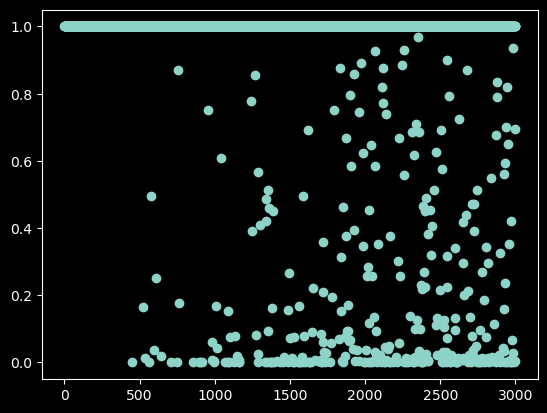

In [22]:
plt.scatter(jnp.arange(3000),acceptance_rates_sc)

In [24]:
print(alphas_sc[-1],alpha)
print(exposures.mean())
print(type(jnp.array(exposures_sc)))

0.4929483 0.4966073
0.33126655
<class 'jaxlib.xla_extension.ArrayImpl'>


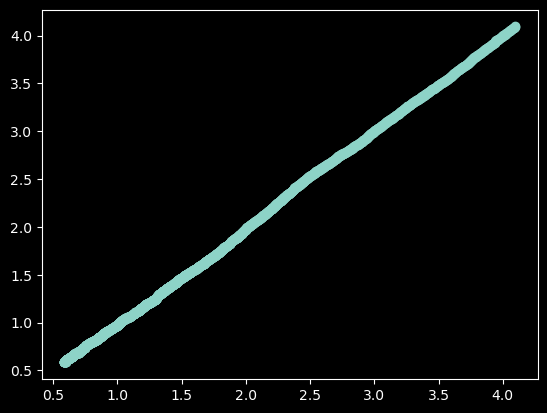

In [25]:
plt.scatter(exposures_sc.mean(axis=1), jnp.array(exposures_lst)[1:].mean(axis=1))
# print(jnp.array(exposures_lst)[1:].shape)

(3000, 500)
0.33126655
0.5875993


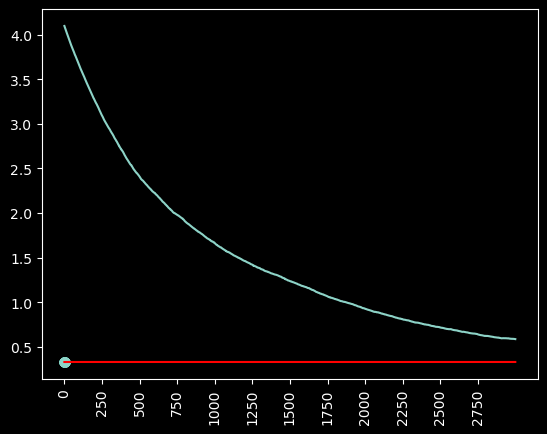

In [27]:
from sympy import rotations


expos_arr = jnp.array(exposures_lst)[1:]
expos_arr = exposures_sc
print(expos_arr.shape)
print(exposures.mean())
plt.scatter(expos_arr.mean(axis=1), jnp.ones(expos_arr.shape[0])*exposures.mean())
print(expos_arr.mean(axis=1)[-1])

# plt.plot(expos_arr)

# create line plot of expos_arr.mean(axis=1) (y axis) vs the index (x axis)
plt.plot(expos_arr.mean(axis=1))
plt.plot(jnp.ones(expos_arr.shape[0])*exposures.mean(), color='red')
# add x-ticks vertical with 500 step siz
plt.xticks(range(0, n_iter, 250), rotation=90) 
plt.show()

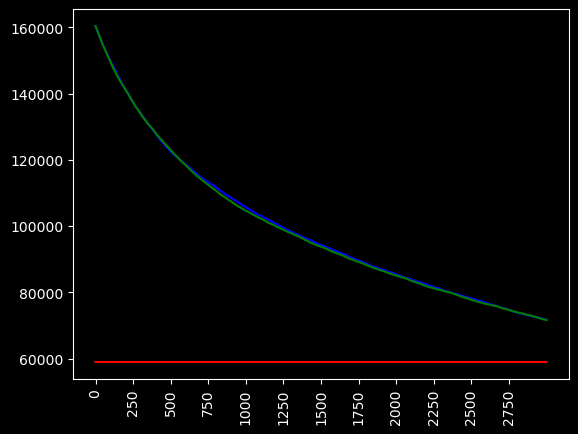

In [28]:
(true_logpost,_), true_grad = val_grad_fn(triu_star, triu_obs, df_edges,
                                            theta, gamma, Y, x, Z, eta)

plt.plot(-jnp.array(log_post_sc), color="blue")
plt.plot(-jnp.array(log_post), color="green")
plt.plot(-jnp.ones(len(log_post))*true_logpost, color="red")
plt.xticks(range(0, n_iter, 250), rotation=90)
plt.show()

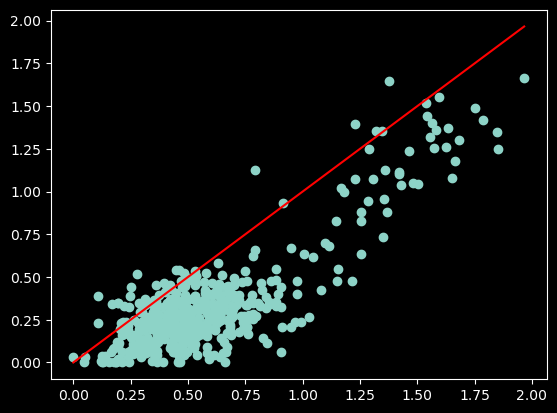

In [29]:
plt.scatter(expos_arr[-1,:], exposures)
# plt.scatter(compute_exposures(triu_obs, Z), exposures)
plt.plot([min(expos_arr[-1,:]), max(expos_arr[-1,:])], [min(expos_arr[-1,:]), max(expos_arr[-1,:])], color='red')

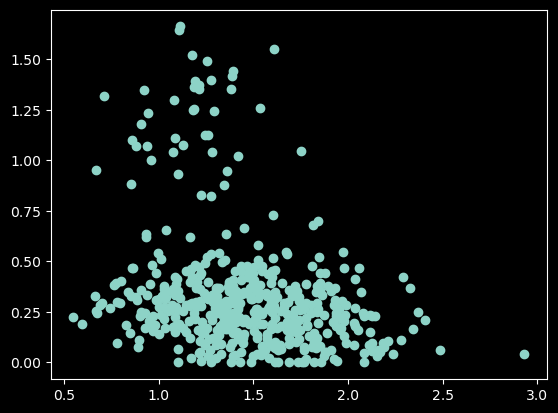

In [30]:
plt.scatter(compute_exposures(triu_obs, Z), exposures)


In [31]:
print(np.corrcoef(expos_arr[-1,:], exposures))
print(np.corrcoef(exposures_sc[-1,:], exposures))
# print(np.corrcoef(compute_exposures(triu_star_noisy, Z), exposures))
print(np.corrcoef(compute_exposures(triu_obs, Z), exposures))

[[1.         0.83746548]
 [0.83746548 1.        ]]
[[1.         0.83746548]
 [0.83746548 1.        ]]
[[ 1.         -0.28469737]
 [-0.28469737  1.        ]]


In [32]:
# print 2x2 table of triu_star and new_triu_star
#  for all values
def binary_contingency_table(A1, A2):
    # Table structure:
    #     A2=0  A2=1
    # A1=0  n00   n01
    # A1=1  n10   n11
    
    n00 = jnp.sum((A1 == 0) & (A2 == 0))
    n01 = jnp.sum((A1 == 0) & (A2 == 1))
    n10 = jnp.sum((A1 == 1) & (A2 == 0))
    n11 = jnp.sum((A1 == 1) & (A2 == 1))
    
    print("A1 \ A2 |  0  |  1  |")
    print("---------|-----|-----|")
    print(f"   0    | {n00:3d} | {n01:3d} |")
    print(f"   1    | {n10:3d} | {n11:3d} |")
    
    return jnp.array([[n00, n01], [n10, n11]])

print(binary_contingency_table(triu_star, new_triu_star))
print(binary_contingency_table(triu_star, final_carry[1]))
print(binary_contingency_table(triu_star, triu_obs))

print(jnp.mean(triu_star == new_triu_star))
print(jnp.mean(triu_star == final_carry[1]))
# print(jnp.mean(triu_star == triu_star_noisy))
print(jnp.mean(triu_star == triu_obs))


# print(jnp.sum(triu_star), jnp.sum(new_triu_star))

A1 \ A2 |  0  |  1  |
---------|-----|-----|
   0    | 114194 | 5510 |
   1    | 2993 | 2053 |
[[114194   5510]
 [  2993   2053]]
A1 \ A2 |  0  |  1  |
---------|-----|-----|
   0    | 114170 | 5534 |
   1    | 3047 | 1999 |
[[114170   5534]
 [  3047   1999]]
A1 \ A2 |  0  |  1  |
---------|-----|-----|
   0    | 111388 | 8316 |
   1    | 4240 | 806 |
[[111388   8316]
 [  4240    806]]
0.93183964
0.9312144
0.89935064


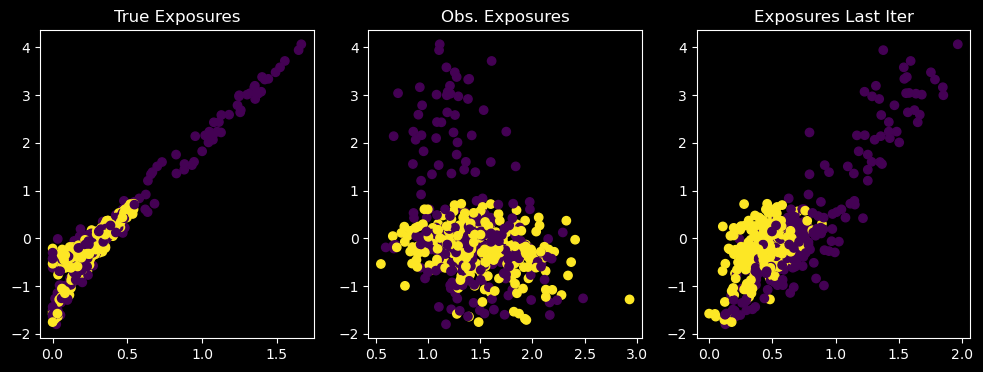

In [33]:
# plot with 3 panels of expos~Y scatter for exposures, expos_obs, expos_arr[-1,:]
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.scatter(exposures, Y-3*Z, c=Z)
plt.title("True Exposures")
plt.subplot(1, 3, 2)
plt.scatter(expos_obs, Y-3*Z, c=Z)
plt.title("Obs. Exposures")
plt.subplot(1, 3, 3)
plt.scatter(expos_arr[-1,:], Y-3*Z, c=Z)
plt.title("Exposures Last Iter")
plt.show()


In [144]:
# Testing blackjax for continuous site (outcome model only)
import blackjax
import blackjax.mcmc.hmc as hmc
from colorama import init
import jax.scipy.stats as stats
import numpyro
import numpyro.distributions as dist
from numpyro.infer.util import initialize_model


def outcome_model(X, Z, triu_star, Y=None):
    # Outcome model
    expos = compute_exposures(triu_star, Z)
    df_nodes = jnp.transpose(jnp.stack([jnp.ones(n), Z, X, expos]))

    # priors
    with numpyro.plate("eta_plate", df_nodes.shape[1]):
        eta = numpyro.sample("eta", dist.Normal(0, 5))
    
    # log_sig_y = numpyro.sample("log_sig_y", dist.Normal(0, 1))
    sig_y = numpyro.sample("sig_y", dist.LogNormal(scale=3.0))
    # likelihood
    # mean_y = jnp.dot(df_nodes, eta)
    mean_y = df_nodes @ eta
    # numpyro.sample("Y", dist.Normal(mean_y, jnp.exp(log_sig_y)), obs=Y)
    numpyro.sample("Y", dist.Normal(mean_y, sig_y), obs=Y)
    
    
def networks_models(triu_star, triu_obs, df_edges):
    # Proxy nets model
    # priors
    with numpyro.plate("gamma_plate", 2):
        gamma = numpyro.sample("gamma", dist.Normal(0, 5))
    
    # likelihood
    obs_logits = triu_star*gamma[0] + (1 - triu_star)*gamma[1]
    # obs_logits = jnp.where(triu_star == 1, gamma[0], gamma[1])
    numpyro.sample("triu_obs", dist.Bernoulli(logits=obs_logits), obs=triu_obs)

    # True network model (given triu_star value)
    # priors
    with numpyro.plate("theta_plate", df_edges.shape[1]):
        theta = numpyro.sample("theta", dist.Normal(0, 5))

    # likelihood
    # star_logits = jnp.dot(df_edges, theta)
    star_logits = df_edges @ theta
    numpyro.sample("triu_star", dist.Bernoulli(logits=star_logits), obs=triu_star)


rng_key, init_key = random.split(key)

init_params_outcome, potential_fn_gen_outcome, *_ = initialize_model(
    init_key,
    outcome_model,
    # model_args=(x, Z, triu_star, triu_obs, df_edges, Y),
    # model_args=(x, Z, triu_obs, triu_obs, df_edges, Y),
    model_args=(x, Z, final_carry[1], Y),
    # model_args=(x, Z, triu_star, Y),
    # model_args=(x, Z, final_carry[1], Y),
    dynamic_args=True
    )

# logdensity_fn = lambda position: -potential_fn_gen(x, Z, triu_star, Y)(position)
# logdensity_fn = lambda position: -potential_fn_gen(x, Z, triu_star, triu_obs, df_edges, Y)(position)
def logdensity_fn_outcome(position):
    return -potential_fn_gen_outcome(x, Z, final_carry[1], Y)(position)
    # return -potential_fn_gen_outcome(x, Z, triu_star, Y)(position)
# logdensity_fn = lambda position: -potential_fn_gen(x, Z, final_carry[1], Y)(position)
initial_position_oc = init_params_outcome.z
print(initial_position_oc)



{'eta': Array([ 1.9350762 ,  0.25582933, -1.4911718 , -0.87775755], dtype=float32), 'sig_y': Array(-1.441443, dtype=float32)}


In [140]:
rng_key, warmup_key = random.split(rng_key)

step_size = 1e-7
# mala kernel
# mala_oc = blackjax.mala(logdensity_fn_outcome, step_size)
mala_oc = blackjax.mala.build_kernel()
# init state
# state = mala_oc.init(initial_position_oc)
state = blackjax.mala.init(initial_position_oc, logdensity_fn_outcome)
# jit compile the kernel step function
# step = jax.jit(mala_oc.step)   
# new_state, info = step(rng_key, state)
new_state, info = mala_oc(rng_key, state, logdensity_fn_outcome, step_size)


In [135]:
def inference_loop(rng_key, kernel, initial_state, logdensity_fn, step_size, num_samples):
# def inference_loop(rng_key, kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, rng_key):
    # def one_step(state, rng_key):
        # state, info = kernel(rng_key, state)
        state, info = kernel(rng_key, state, logdensity_fn, step_size)
        return state, (state, info.acceptance_rate)

    keys = random.split(rng_key, num_samples)
    # _, (states, acc_rate) = jax.lax.scan(one_step, initial_state, keys, logdensity_fn, step_size)
    _, (states, acc_rate) = jax.lax.scan(one_step, initial_state, keys)

    return states, (acc_rate)


num_sample = 50000
rng_key, sample_key = random.split(rng_key)
# states, acc_rates = inference_loop(sample_key, step, new_state, num_sample)
states, acc_rates = inference_loop(sample_key, mala_oc, new_state, logdensity_fn_outcome, 1e-6, num_sample)
# _ = states.position["mu"].block_until_ready()

In [148]:
from typing import NamedTuple, Any

class AdaptState(NamedTuple):
    state: Any  # MALA state
    step_size: float
    mean_acceptance: float
    iteration: int  

def inference_loop(
    rng_key, 
    kernel, 
    initial_state, 
    logdensity_fn, 
    initial_step_size: float,
    num_samples: int,
    adapt_window: int = 50,  # New parameter
    target_acceptance: float = 0.574,
    adaptation_rate: float = 0.1
):
    def one_step(carry, key):
        adapt_state = carry
        
        # Run MALA step
        new_state, info = kernel(
            key, 
            adapt_state.state, 
            logdensity_fn, 
            adapt_state.step_size
        )
        
        # Update step size only every adapt_every iterations
        should_adapt = (adapt_state.iteration + 1) % adapt_window == 0
        log_step = jnp.log(adapt_state.step_size)
        log_step = jnp.where(
            should_adapt,
            log_step + adaptation_rate * (info.acceptance_rate - target_acceptance),
            log_step
        )
        new_step_size = jnp.exp(log_step)
        
        # Update mean acceptance rate
        new_mean_acc = adapt_state.mean_acceptance + (
            info.acceptance_rate - adapt_state.mean_acceptance
        ) / (adapt_state.iteration + 1)
        
        new_adapt_state = AdaptState(
            state=new_state,
            step_size=new_step_size,
            mean_acceptance=new_mean_acc,
            iteration=adapt_state.iteration + 1
        )
        
        return new_adapt_state, (new_state, info.acceptance_rate, new_step_size)

    keys = random.split(rng_key, num_samples)
    init_adapt_state = AdaptState(
        state=initial_state,
        step_size=initial_step_size,
        mean_acceptance=0.0,
        iteration=0
    )
    
    _, (states, acc_rates, step_sizes) = jax.lax.scan(one_step, init_adapt_state, keys)
    
    return states, acc_rates, step_sizes
# Usage:
states, acc_rates, step_sizes = inference_loop(
    sample_key,
    mala_oc,
    new_state, 
    logdensity_fn_outcome,
    initial_step_size=1e-5,
    num_samples=40000
)

0.6123238 7.604791e-05


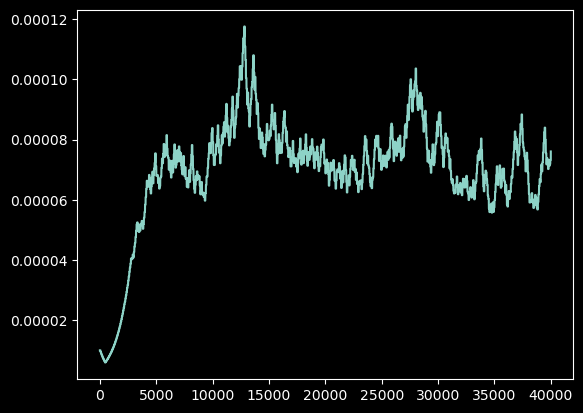

In [149]:
print(acc_rates.mean(), step_sizes[-1])
plt.plot(step_sizes)

In [150]:
eta_post = states.position["eta"][5000:,:]
sig_post = jnp.exp(states.position["sig_y"][5000:])
print("mean +- std by axis=1 ", jnp.mean(eta_post, axis=0), jnp.std(eta_post, axis=0))
print("mean +- std by axis=1 ", jnp.mean(sig_post, axis=0), jnp.std(sig_post, axis=0))
# gamma_post = states.position["gamma"][30000:,:]
# print("mean +- std by axis=1 ", jnp.mean(gamma_post, axis=0), jnp.std(gamma_post, axis=0))

mean +- std by axis=1  [-1.6780318   3.3332145   0.05040859  2.5645714 ] [0.06589081 0.05261091 0.00694198 0.07381941]
mean +- std by axis=1  0.47053862 0.014600718


In [222]:
acceptance_rate = np.mean(infos)
# num_divergent = np.mean(infos[1])

print(f"\Average acceptance rate: {acceptance_rate:.2f}")

print("true gamma: ", gamma, "\n",
      "true eta: ", eta, "\n",
      "true theta: ", theta)

# print(f"There were {100*num_divergent:.2f}% divergent transitions")

\Average acceptance rate: 0.92
true gamma:  [ 2.1972244 -2.1972246] 
 true eta:  [-1.    3.   -0.25  3.  ] 
 true theta:  [-2.5 -0.5  1.5]


In [151]:
import matplotlib.pyplot as plt
import arviz as az

idata = az.from_dict(posterior={k: v[None, ...] for k, v in states.position.items()})
az.summary(idata)

arviz - WARNING - Shape validation failed: input_shape: (1, 40000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
eta[0],-1.464,0.772,-1.898,0.235,0.287,0.212,25.0,10.0,NaN
eta[1],3.180,0.581,2.317,3.502,0.207,0.160,24.0,10.0,NaN
eta[2],0.037,0.163,0.028,0.098,0.018,0.018,74.0,11.0,NaN
eta[3],2.346,0.773,0.292,2.813,0.292,0.223,26.0,10.0,NaN
sig_y,-0.712,0.216,-0.849,-0.195,0.052,0.038,70.0,11.0,NaN


In [ ]:
# TODO: create blackjax code of MALA with adaptive step size using Dual Averaging
# TODO: seperate continuous models to two: outcome (eta) and networks (gamma, theta)
# TODO: combine continuous and discrete models in one wrap function. See blackjax guide for wrapping
# TODO: the functio (^) should do warm-up stage with adaptive step size for each algo and then run the sampling
# TODO: probably preferable for now to use MALA for continuous sites due to adaptive hyper-param issues with NUTS/HMC
# TODO: Optional: think about Zhou 2020 'mixed HMC' paper for combining discrete and continuous sites in one model
# TODO: Re: ^, see https://arxiv.org/abs/2201.08044 as well
# TODO: see this paper https://openreview.net/forum?id=obP4120Bt34 that did sampling in mixed spaces
# TODO: think about initialisation startegies for latent variables (e.g. triu_star) in the model 